Name: Christian Hellum Bye \
E-mail: chbye@berkeley.edu \
Date: 4/19/22

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
DATA_FILE = "location_data_hw8_2022.csv"
with open(DATA_FILE) as f: header = f.readline(); print(header)
data = np.loadtxt(DATA_FILE, skiprows=1, delimiter=",")

t,red_pos_X,red_pos_Y,blue_pos_X,blue_pos_Y



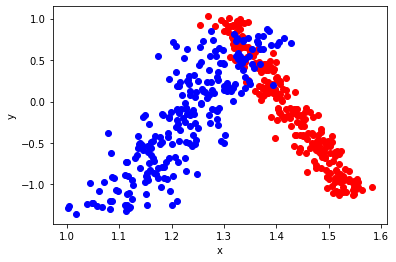

In [3]:
plt.figure()
for i, color in enumerate(["red", "blue"]):
    x_idx = 2 * i + 1
    y_idx = x_idx + 1
    x = data[:, x_idx]
    y = data[:, y_idx]
    plt.scatter(x, y, c=color)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

We don't know what units these measurements are in, so for ease of notation we will assume the lenght units are meters [m] and the time units are seconds [s]. The unit of speed is thus m/s. We note that the choice of units are arbitrary.

In [4]:
print("Total time of motion is {:.2f}s.".format(data[:, 0].max() - data[:, 0].min()))

Total time of motion is 942.10s.


The objects are moving across a range of order $\Delta l \sim 1$m in a time of $\Delta t \approx 1000$s. This indicates that the speed of the objects should be of order $v \sim 10^{-3}$m/s.

Since we assume the velocity of each object is constant in magnitude and direction, we can in principle measure the velocity at time step $i$ by computing 
$$\frac{x_{i+1}-x_{i}}{t_{i+1}-t_{i}}$$.

We convert the position measurements to a set of time measurements:

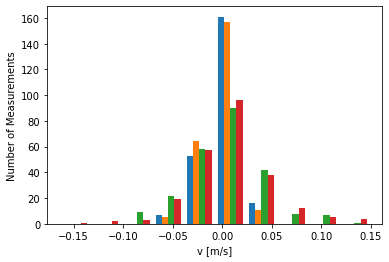

In [5]:
dt = np.diff(data[:, 0])  # delta times
v_rx = np.diff(data[:, 1])/dt  # red object, x-direction
v_ry = np.diff(data[:, 2])/dt  # red object, y-direction
v_bx = np.diff(data[:, 3])/dt  # blue object, x-direction
v_by = np.diff(data[:, 4])/dt  # blue object, y-direction

v_data = np.array([v_rx, v_ry, v_bx, v_by])

plt.figure()
plt.hist([v_rx, v_ry, v_bx, v_by])
plt.xlabel("v [m/s]")
plt.ylabel("Number of Measurements")
plt.show()

The likelihood distribution of the velocities is certainly a Gaussian distribution since the position data has Gaussian random noise and the speed is computed from two position measurements $x_1$, $x_2$ by $v=\frac{x_2-x_1}{\Delta t}$. The noise is independent and identically distributed the variance of the Gaussians are the same for the four unknown quantities ($v_x$ and $v_y$ for both objects). However, there is no reasons for the means of the distributions to be the same. As the noise is unknown, we sample the variance of the likelihood distribution, $\sigma^2$ from a uniform distribution of values 0-0.05 $\rm{(m/s)}^2$.

For the prior, we don't have much information about the velocities or much physical intuition about the system. We therefore pick uniform priors across the range $-0.2 - +0.2$ m/s for each velocity component, which is a wide range that spans all of the measured velocities.

In [6]:
# bounds on prior velocity dist (m/s)
V_LO = -.2
V_HI = .2


with pm.Model() as model:
    # noise variance
    var = pm.Uniform("var", 0, 0.05)
    
    # red, x-direction
    mu_rx = pm.Uniform("mu_rx", V_LO, V_HI)  # prior
    data_rx = pm.Data("data_rx", v_rx)
    X_rx = pm.Normal("X_rx", mu=mu_rx, sigma=np.sqrt(var), observed=data_rx)
    
    # red, y-direction
    mu_ry = pm.Uniform("mu_ry", V_LO, V_HI)  # prior
    data_ry = pm.Data("data_ry", v_ry)
    X_ry = pm.Normal("X_ry", mu=mu_ry, sigma=np.sqrt(var), observed=data_ry)
    
    # speed, red
    s_red = pm.Deterministic("s_red", np.sqrt(mu_rx**2+mu_ry**2))
    
    # blue, x-direction
    mu_bx = pm.Uniform("mu_bx", V_LO, V_HI)  # prior
    data_bx = pm.Data("data", v_bx)
    X_bx = pm.Normal("X_bx", mu=mu_bx, sigma=np.sqrt(var), observed=data_bx)
    
    # blue, y-direction
    mu_by = pm.Uniform("mu_by", V_LO, V_HI)  # prior
    data_by = pm.Data("data_by", v_by)
    X_by = pm.Normal("X_by", mu=mu_by, sigma=np.sqrt(var), observed=data_by)
    
    
    # speed, blue
    s_blue = pm.Deterministic("s_blue", np.sqrt(mu_bx**2+mu_by**2))
    
with model:
    step = pm.NUTS()
    #step = pm.Metropolis()
    trace = pm.sample(50000, step=[step], cores=4, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_by, mu_bx, mu_ry, mu_rx, var]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 41 seconds.


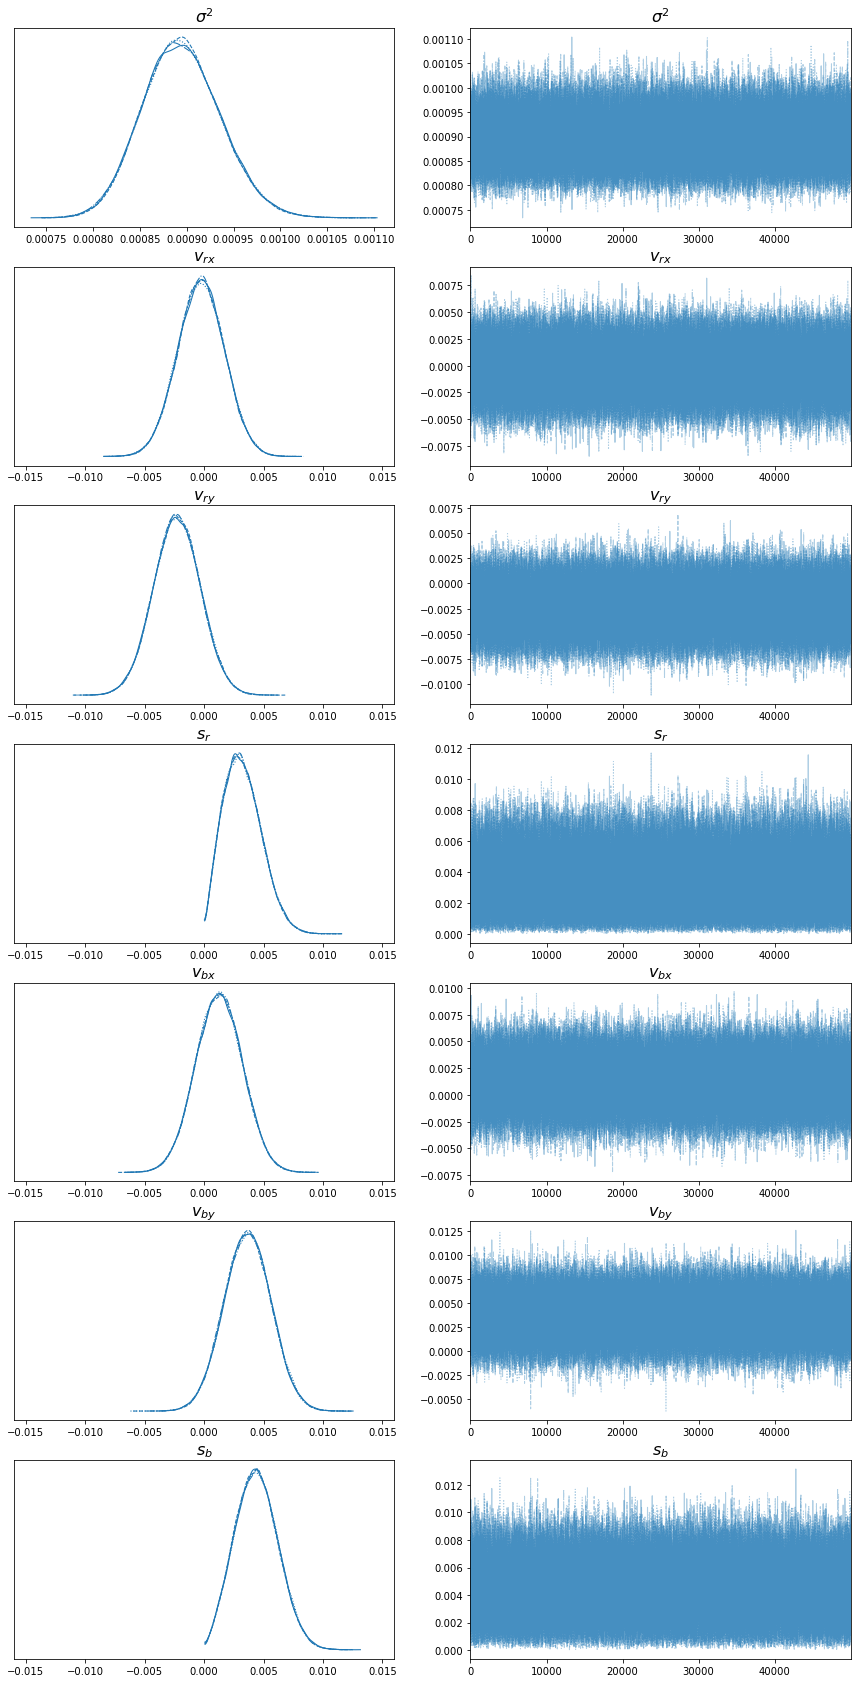

In [7]:
# Plot the traces
TITLE_SIZE = 16

import arviz as az
with model:
    axs = az.plot_trace(
        trace,
        figsize=(15,30),
        legend=False,
    )
    
    titles = ["$\\sigma^2$", "$v_{rx}$", "$v_{ry}$", "$s_r$", "$v_{bx}$", "$v_{by}$", "$s_b$"]
    for i, t in enumerate(titles):
        axs[i, 0].set_title(t, fontsize=TITLE_SIZE)
        axs[i, 1].set_title(t, fontsize=TITLE_SIZE)
    
    plt.setp(axs[1:, 0], xlim=(-0.016, 0.016))

From the above trace plots, we can see that the different sampling chains all give approximately the same results. Below, we plot the properly normalized distributions after averaging across chains and using burn-in and pruning to reduce bias:

In [8]:
sred = trace.get_values("s_red", burn=1000, thin=5, combine=True)
sblue = trace.get_values("s_blue", burn=1000, thin=5, combine=True)

In [9]:
# get expectation values
EV_red = sred.sum(axis=0)/len(sred)
EV_blue = sblue.sum(axis=0)/len(sblue)
EVs = [EV_red, EV_blue]

for i, color in enumerate(["red", "blue"]):
    print(f"The speed of the {color} object has an expected value of {EVs[i]:.2g} m/s.")

The speed of the red object has an expected value of 0.0032 m/s.
The speed of the blue object has an expected value of 0.0044 m/s.


# PART A)

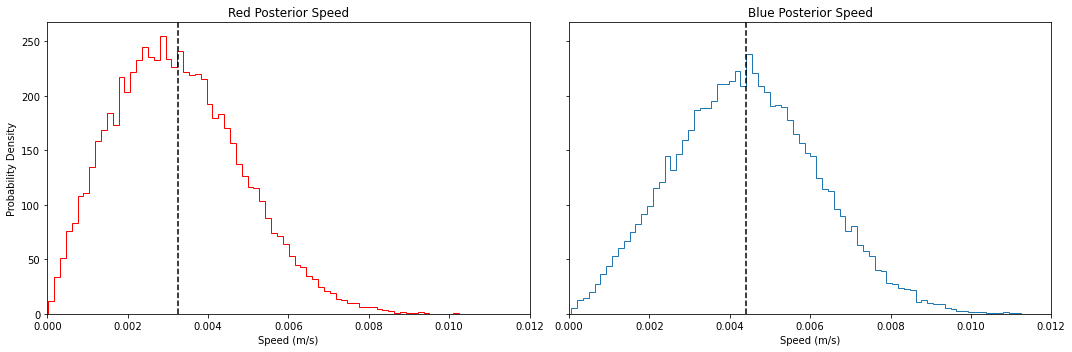

In [10]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=2, sharex=True, sharey=True)

_ = axs[0].hist(sred, density=True, bins=80, histtype="step", color="red")
_ = axs[1].hist(sblue, density=True, bins=80, histtype="step")

axs[0].axvline(EV_red, color="k", ls="--")
axs[1].axvline(EV_blue, color="k", ls="--")

axs[0].set_title("Red Posterior Speed")
axs[1].set_title("Blue Posterior Speed")

plt.setp(axs, xlim=(0, 0.012), xlabel="Speed (m/s)")
axs[0].set_ylabel("Probability Density")
plt.tight_layout()

plt.show()

# PART B)

The idea for part B is to draw y-velocities from the posterior distribution and fit a line to the position measurements. The uncertainty on the position measurements are drawn from the posterior distribution of the velocity variance -- they are related by $\sigma_{\rm position} = \sigma_{\rm velocity} / \sqrt{2}$ since the velocity is computed from two position measurements. 

In [6]:
def position_fcn(velocity):
    """
    Function that returns the function to fit given the velocity sampled. 
    """
    def fit(time, x0):
        return x0 + time * velocity
    return fit

In [13]:
# sample from posterior
with model:
    post_pred = pm.sample_posterior_predictive(trace, var_names=["var", "mu_ry", "mu_by"])

In [14]:
from scipy.optimize import curve_fit
times = data[:, 0]
red_y_pos = data[:, 2]
blue_y_pos = data[:, 4]

vel_red = post_pred["mu_ry"]
vel_blue = post_pred["mu_by"]
var_pp = post_pred["var"]

first_times = np.empty_like(var_pp)

for i in range(len(var_pp)):
    sigma = np.sqrt(var_pp[i] / 2)  # standard dev of position measurement
    
    
    # fit for red y-position
    vr = vel_red[i]  # get velocity
    fit_red = position_fcn(vr)  # get the fitting function
    x0_red, _ = curve_fit(fit_red, times, red_y_pos, sigma=np.full_like(times, sigma))  # determine initial pos.
    red_positions = fit_red(times, x0_red)
    
    # fit for blue y-position
    vb = vel_blue[i]
    fit_blue = position_fcn(vb)
    x0_blue, _ = curve_fit(fit_blue, times, blue_y_pos, sigma=np.full_like(times, sigma))
    blue_positions = fit_blue(times, x0_blue)
    
    
    cond = (red_positions <= 0) * (blue_positions >= 0)  # what we are looking for
    
    # the condition might never be true if the velocity is in the wrong direction
    try:
        first_time = np.nonzero(cond)[0][0]
    except(IndexError):
        first_time = np.nan
    
    first_times[i] = first_time

In [15]:
# about 7 % of the times gives a nan.These correspond to the condition never being true (so t = infinity)
print(len(np.nonzero(np.isnan(first_times))[0])/len(first_times)*100)

# we will just set these to the largest crossing time
first_times[np.isnan(first_times)] = first_times[~np.isnan(first_times)].max()

6.7989999999999995


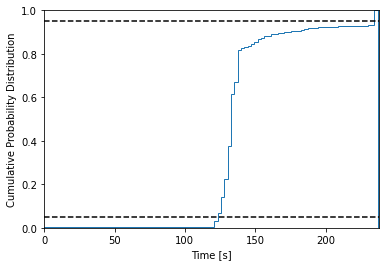

In [16]:
# the histogram
# the peak at the highest value is artificial since we binned the never-crossings (nans) to that time

plt.figure()
_ = plt.hist(first_times, bins=100, density=True, histtype="step", cumulative=True)
plt.ylabel("Cumulative Probability Distribution")
plt.xlabel("Time [s]")
plt.axhline(0.05, ls="--", color="k")
plt.axhline(0.95, ls="--", color="k")
plt.xlim(0,238)
plt.ylim(0,1)
plt.show()

In [17]:
print(np.percentile(first_times, 5))
print(np.percentile(first_times, 95))

124.0
237.0


The 95% confidence interval is given by t = (124s, 237s)

# PART C)

If both are moving at the same speed then we can sample the speed and direction (as an angle in the xy-plane) instead of the speed in each direction that we did before.

In [28]:
# bounds on prior speed dist (m/s)
S_LO = 0  # lowest possible speed is if the velocity is 0 in both directions
S_HI = np.sqrt(2) * V_HI  # highest possible speed is if the velocity is maximum in both directions


with pm.Model() as model2:
    # noise variance (unchanged from before)
    var = pm.Uniform("var", 0., 0.05)
    
    speed = pm.Uniform("speed", S_LO, S_HI)  # prior
    
    # red
    red_dir = pm.Uniform("red_dir", 0, 2*np.pi)  # the angle in the xy-plane
    mu_rx = pm.Deterministic("mu_rx", np.cos(red_dir) * speed)  # x-component
    mu_ry = pm.Deterministic("mu_ry", np.sin(red_dir) * speed)  # y-component
    data_rx = pm.Data("data_rx", v_rx)
    data_ry = pm.Data("data_ry", v_ry)
    X_rx = pm.Normal("X_rx", mu=mu_rx, sigma=np.sqrt(var), observed=data_rx)
    X_ry = pm.Normal("X_ry", mu=mu_ry, sigma=np.sqrt(var), observed=data_ry)
    
    # blue
    blue_dir = pm.Uniform("blue_dir", 0, 2*np.pi)  # the angle in the xy-plane
    mu_bx = pm.Deterministic("mu_bx", np.cos(blue_dir) * speed)  # x-component
    mu_by = pm.Deterministic("mu_by", np.sin(blue_dir) * speed)  # y-component    
    data_bx = pm.Data("data", v_bx)
    data_by = pm.Data("data_by", v_by)
    X_bx = pm.Normal("X_bx", mu=mu_bx, sigma=np.sqrt(var), observed=data_bx)
    X_by = pm.Normal("X_by", mu=mu_by, sigma=np.sqrt(var), observed=data_by)    
    
with model2:
    step2 = pm.NUTS()
    trace2 = pm.sample(50000, step=[step2], cores=4, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_dir, red_dir, speed, var]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 51 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


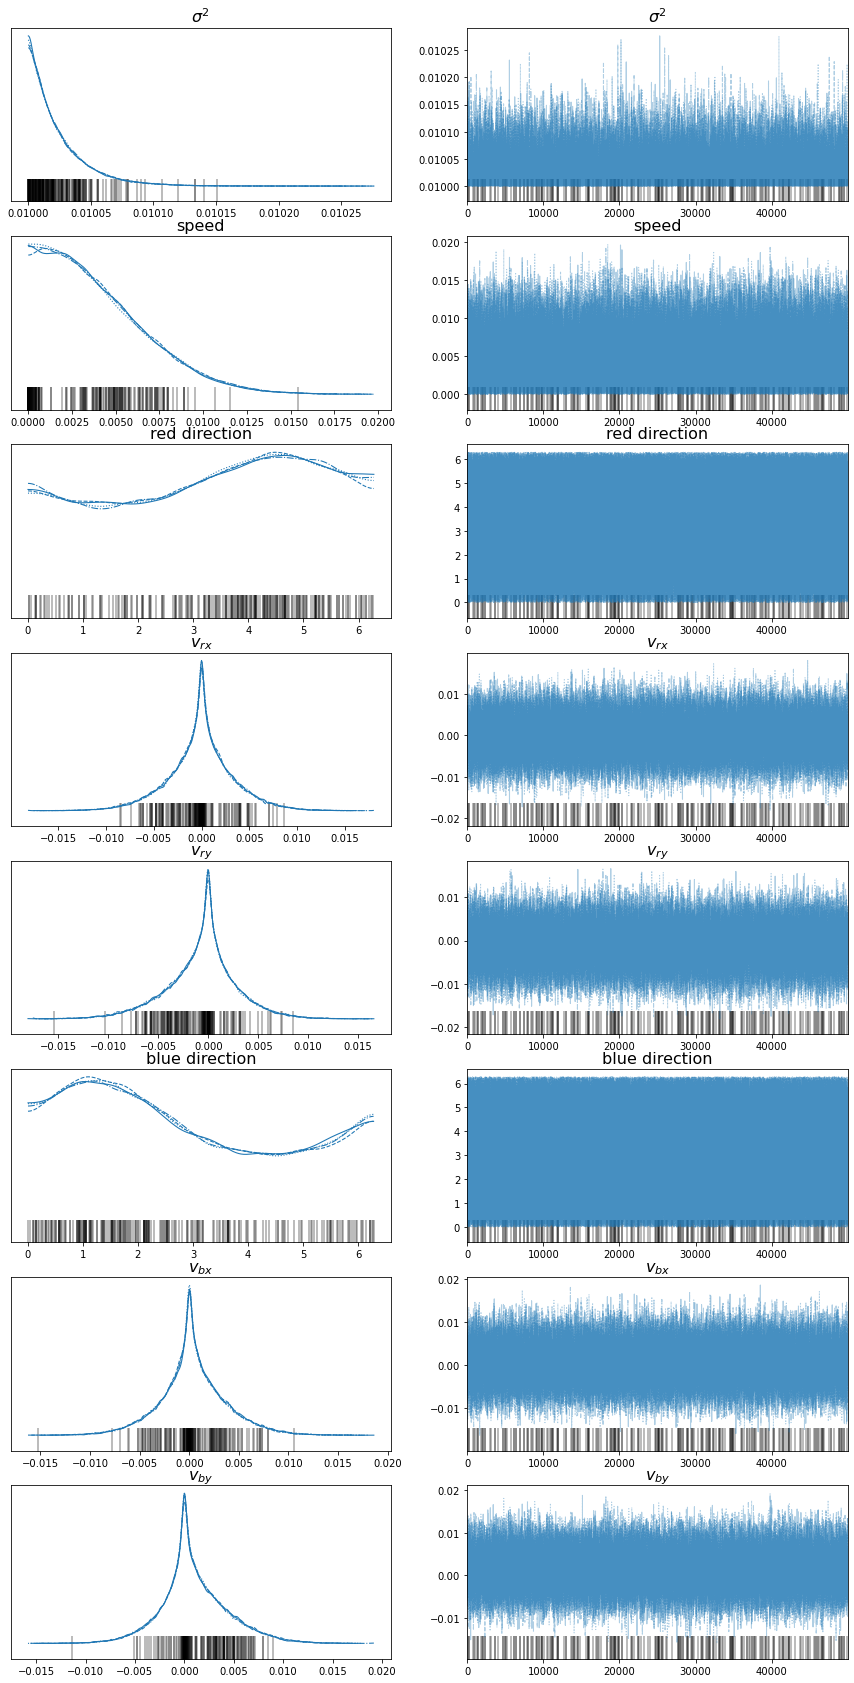

In [31]:
# Plot the traces
with model2:
    axs = az.plot_trace(
        trace2,
        figsize=(15,30),
        legend=False,
    )
    
    titles = ["$\\sigma^2$", "speed", "red direction", "$v_{rx}$", "$v_{ry}$", "blue direction",
              "$v_{bx}$", "$v_{by}$"]
    for i, t in enumerate(titles):
        axs[i, 0].set_title(t, fontsize=TITLE_SIZE)
        axs[i, 1].set_title(t, fontsize=TITLE_SIZE)
    
    #plt.setp(axs[1:, 0], xlim=(-0.016, 0.016))

In [32]:
# get expectation values
speed = trace2.get_values("speed", burn=1000, thin=5, combine=True)
EV_speed = speed.sum(axis=0)/len(speed)

print(f"The speed of the objects has an expected value of {EV_speed:.2g} m/s.")

The speed of the objects has an expected value of 0.004 m/s.


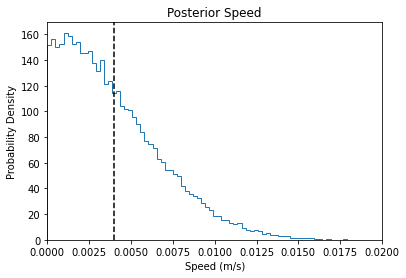

In [33]:
# part A again
plt.figure()
_ = plt.hist(speed, density=True, bins=80, histtype="step")
plt.axvline(EV_speed, color="k", ls="--")
plt.title("Posterior Speed")
plt.xlim(0, 0.02)
plt.xlabel("Speed (m/s)")
plt.ylabel("Probability Density")
plt.show()

## Part A: 
We earlier had that the red object had an expected speed of 0.0032 m/s and the blue object had an expected speed of 0.0044 m/s. When the speed is forced to be the same for both, the expected value is somehwere in the middle: 0.0040 m/s. It is closer to the blue object speed from before as the blue speed was more constrained.

In [34]:
# sample from posterior
with model2:
    post_pred = pm.sample_posterior_predictive(trace2, var_names=["var", "mu_ry", "mu_by"])

In [35]:
vel_red = post_pred["mu_ry"]
vel_blue = post_pred["mu_by"]
var_pp = post_pred["var"]

first_times = np.empty_like(var_pp)

for i in range(len(var_pp)):
    sigma = np.sqrt(var_pp[i] / 2)  # standard dev of position measurement
    
    
    # fit for red y-position
    vr = vel_red[i]  # get velocity
    fit_red = position_fcn(vr)  # get the fitting function
    x0_red, _ = curve_fit(fit_red, times, red_y_pos, sigma=np.full_like(times, sigma))  # determine initial pos.
    red_positions = fit_red(times, x0_red)
    
    # fit for blue y-position
    vb = vel_blue[i]
    fit_blue = position_fcn(vb)
    x0_blue, _ = curve_fit(fit_blue, times, blue_y_pos, sigma=np.full_like(times, sigma))
    blue_positions = fit_blue(times, x0_blue)
    
    
    cond = (red_positions <= 0) * (blue_positions >= 0)  # what we are looking for
    
    # the condition might never be true if the velocity is in the wrong direction
    try:
        first_time = np.nonzero(cond)[0][0]
    except(IndexError):
        first_time = np.nan
    
    first_times[i] = first_time
    
# about 7 % of the times gives a nan.These correspond to the condition never being true (so t = infinity)
print(len(np.nonzero(np.isnan(first_times))[0])/len(first_times)*100)

# we will just set these to the largest crossing time
first_times[np.isnan(first_times)] = first_times[~np.isnan(first_times)].max()

47.1825


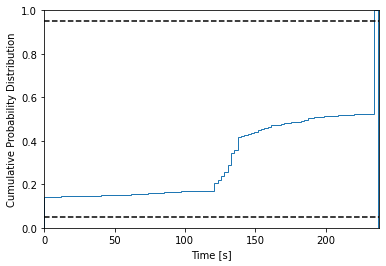

In [36]:
# the histogram
# the peak at the highest value is artificial since we binned the never-crossings (nans) to that time

plt.figure()
_ = plt.hist(first_times, bins=100, density=True, histtype="step", cumulative=True)
plt.ylabel("Cumulative Probability Distribution")
plt.xlabel("Time [s]")
plt.axhline(0.05, ls="--", color="k")
plt.axhline(0.95, ls="--", color="k")
plt.xlim(0,238)
plt.ylim(0,1)
plt.show()

In [37]:
print(np.percentile(first_times, 5))
print(np.percentile(first_times, 95))

0.0
237.0


The 95% confidence interval is given by t = (135s, 237s)

## Part B:
The 95% confidence interval was constrained to later times as the condition was almost never actually met. With the speed jointly fit, the model disfavored large y-speeds

# PART D)

## Part A:

In [41]:
with pm.Model() as model:
    # noise variance
    var = pm.Uniform("var", 0, 0.05)
    
    # red, x-direction
    mu_rx = pm.Uniform("mu_rx", V_LO, V_HI)  # prior
    data_rx = pm.Data("data_rx", v_rx[:100])  # HERE: first 100 only
    X_rx = pm.Normal("X_rx", mu=mu_rx, sigma=np.sqrt(var), observed=data_rx)
    
    # red, y-direction
    mu_ry = pm.Uniform("mu_ry", V_LO, V_HI)  # prior
    data_ry = pm.Data("data_ry", v_ry[:100])
    X_ry = pm.Normal("X_ry", mu=mu_ry, sigma=np.sqrt(var), observed=data_ry)
    
    # speed, red
    s_red = pm.Deterministic("s_red", np.sqrt(mu_rx**2+mu_ry**2))
    
    # blue, x-direction
    mu_bx = pm.Uniform("mu_bx", V_LO, V_HI)  # prior
    data_bx = pm.Data("data", v_bx[:100])
    X_bx = pm.Normal("X_bx", mu=mu_bx, sigma=np.sqrt(var), observed=data_bx)
    
    # blue, y-direction
    mu_by = pm.Uniform("mu_by", V_LO, V_HI)  # prior
    data_by = pm.Data("data_by", v_by[:100])
    X_by = pm.Normal("X_by", mu=mu_by, sigma=np.sqrt(var), observed=data_by)
    
    
    # speed, blue
    s_blue = pm.Deterministic("s_blue", np.sqrt(mu_bx**2+mu_by**2))
    
with model:
    step = pm.NUTS()
    #step = pm.Metropolis()
    trace = pm.sample(50000, step=[step], cores=4, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_by, mu_bx, mu_ry, mu_rx, var]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 41 seconds.


In [ ]:
# Plot the traces
with model:
    axs = az.plot_trace(
        trace,
        figsize=(15,30),
        legend=False,
    )
    
    titles = ["$\\sigma^2$", "$v_{rx}$", "$v_{ry}$", "$s_r$", "$v_{bx}$", "$v_{by}$", "$s_b$"]
    for i, t in enumerate(titles):
        axs[i, 0].set_title(t, fontsize=TITLE_SIZE)
        axs[i, 1].set_title(t, fontsize=TITLE_SIZE)
    
#    plt.setp(axs[1:, 0], xlim=(-0.016, 0.016))

In [ ]:
sred = trace.get_values("s_red", burn=1000, thin=5, combine=True)
sblue = trace.get_values("s_blue", burn=1000, thin=5, combine=True)

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=2, sharex=True, sharey=True)

_ = axs[0].hist(sred, density=True, bins=80, histtype="step", color="red")
_ = axs[1].hist(sblue, density=True, bins=80, histtype="step")

axs[0].axvline(EV_red, color="k", ls="--")
axs[1].axvline(EV_blue, color="k", ls="--")

axs[0].set_title("Red Posterior Speed")
axs[1].set_title("Blue Posterior Speed")

plt.setp(axs, xlim=(0, 0.012), xlabel="Speed (m/s)")
axs[0].set_ylabel("Probability Density")
plt.tight_layout()

plt.show()

Compared to before, the posterior distribution is wider. T